### Chapter 3
# Classification
### MNIST
The MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

Fetch the MNIST dataset:

In [40]:
import numpy as np

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [41]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Let's look at these arrays:

In [42]:
X, y =  mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [43]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s imshow() function:

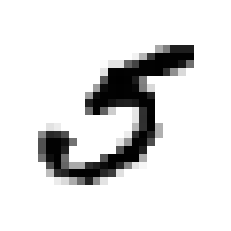

In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [45]:
y[36000]

5

Always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Training set should be shuffled, because:
- this will guarantee that all cross-validation folds will be similar
- some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.


In [47]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier
Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. A *binary classifier*, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [48]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Start with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently.  Let’s create an SGDClassifier and train it on the whole training set:

In [49]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now use it to detect images of the number 5:

In [50]:
sgd_clf.predict([some_digit])

array([False])

The classifier guesses that this image represents a 5 (True).

# Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor

### Measuring Accuracy Using Cross-Validation
Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds:

In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9551 , 0.9594 , 0.94825])

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [52]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Model’s accuracy? Let’s find out:

In [53]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9102 , 0.9111 , 0.90765])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

### Confusion Matrix
A much better way to evaluate the performance of a classifier. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute Confusion matrix, need a set of predictions, so they can be compared to the actual targets. Use the cross_val_predict() function:

In [54]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean (means the predition is made by a model that never saw the data during training) prediction for each instance in the training set.

In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53324,  1255],
       [ 1490,  3931]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*.

First row: Non-5s (*the negative class*):
- 53011 were correctly classified as non-5s: *true negatives*
- 1568 were wrongly classified as 5s: *false positives*

Second row: 5s (*the positive class*)
- 841 were wrongly classified as non-5s: *false negatives*
- 4580 were correctly classified as 5s: *true positives*

A perfect classifier would have only true positives and true negatives:

In [56]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision(*accuracy*: TP in FP+TP) and recall(*sensitivity*: TP in FN+RP):

In [57]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4580/ (4580 + 1568)

0.7580023139220979

In [58]:
recall_score(y_train_5, y_train_pred) # == 4580/ (4580 + 841)

0.7251429625530345

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 74% of the time. Moreover, it only detects 84% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

In [59]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7412086358065428

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

Unfortunately, you can’t have it both ways: increasing precision reduces recall, an vice versa. This is called the *precision/recall tradeoff*.

### Precision/Recall Tradeoff
let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want:

In [60]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-515.02946246])

In [61]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [62]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000.

So to decide which threshold to use. First need to get the scores of all instances in the training set using the cross_val_predict() function, specify it to return decision scores instead of predictions:

In [63]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

In [64]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, plot precision and recall as functions of the threshold value using Matplotlib:

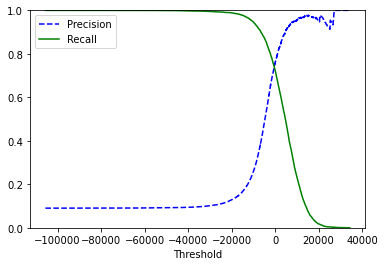

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now select the threshold value that gives you the best precision/recall tradeoff for your task.

So let’s suppose you decide to aim for 90% precision. You look up the plot and find that you need to use a threshold of about 5,000. To make predictions, instead of calling the classifier’s predict() method, you can just run this code:

In [113]:
(y_train_pred == (y_scores > 0)).all()

True

In [114]:
y_train_pred_90 = (y_scores > 5000)

Let's check these predictions' precision and recall:

In [115]:
precision_score(y_train_5, y_train_pred_90)

0.9080539232630488

In [116]:
recall_score(y_train_5, y_train_pred_90)

0.48459693783434793

90% precision classifier! Easy to create a classifier with virtually any precision you want: just set a high enough threshold. A high-precision classifier is not very useful if its recall is too low!

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

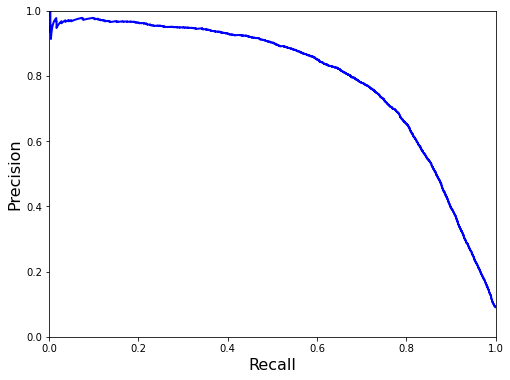

In [120]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# save_fig("precision_vs_recall_plot")
plt.show()

Precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop.

### The ROC Curve


In [118]:
y_train_pred_90.sum()

2893